<a href="https://colab.research.google.com/github/palakchanchlani/Crunchbase-dataset/blob/main/Copy_of_crunchbase_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install
!pip install xgboost imbalanced-learn --quiet


In [ ]:
# Choose which dataset to run. Upload the file to Colab first.
# Set one of these file paths per run:
FILE_PATH = "/content/drive/MyDrive/finale.csv"

import pandas as pd
import numpy as np

df = pd.read_csv(FILE_PATH)
print("Loaded:", FILE_PATH, "Shape:", df.shape)
display(df.head())


Loaded: /content/drive/MyDrive/finale.csv Shape: (196498, 26)


,id,category_code,status,founded_at,logo_width,logo_height,country_code,investment_rounds,invested_companies,funding_rounds,...,num_acquisizioni_effettuate,acquired_object_id,funded_object_id_x,fin_org_financed,funded_object_id_y,person_financed,funded_object_id,startup_financed,parent_id,num_prodotti
0,c:1,web,operating,2005-10-17,401,54,USA,0,0,3,...,0.0,NaN,c:1,9.0,NaN,0.0,NaN,0.0,c:1,2.0
1,c:10,games_video,acquired,NaN,186,85,USA,0,0,0,...,0.0,c:10,NaN,0.0,NaN,0.0,NaN,0.0,c:10,1.0
2,c:100,games_video,acquired,NaN,107,34,USA,0,0,0,...,0.0,c:100,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
3,c:10000,network_hosting,operating,2008-07-26,0,0,NaN,0,0,0,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
4,c:10001,games_video,operating,2008-07-26,200,74,NaN,0,0,0,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Auto-detect target column
candidates = [
    'is_successful', 'is_success', 'outcome', 'status', 'successful', 'target', 'label', 'state'
]

target = None
for c in candidates:
    if c in df.columns:
        target = c
        break

if target is None:
    # Fallback: last column but show hint
    print("No common target found. Showing unique counts to help you choose:")
    for c in df.columns[:20]:
        print(f"{c}: {df[c].nunique()} unique")
    target = df.columns[-1]
    print("Fallback target:", target)

print("USING target column:", target)

# Replace inf
df = df.replace([np.inf, -np.inf], np.nan)

# Basic missing handling: numeric -> median, categorical -> 'NA'
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna('NA')

print("Missing summary (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


USING target column: status
Missing summary (top 10):
id                    0
category_code         0
status                0
founded_at            0
logo_width            0
logo_height           0
country_code          0
investment_rounds     0
invested_companies    0
funding_rounds        0
dtype: int64


In [ ]:
# Light feature engineering (optional and safe)
for c in df.columns:
    name = c.lower()
    if 'date' in name or 'launch' in name or 'created' in name or 'open_' in name or 'close_' in name:
        try:
            df[c] = pd.to_datetime(df[c], errors='coerce')
        except:
            pass

# Duration example if open/close dates exist
if {'open_date','close_date'}.issubset(df.columns):
    df['duration_days'] = (pd.to_datetime(df['close_date']) - pd.to_datetime(df['open_date'])).dt.days.fillna(0)

# Text length features for common columns
for text_col in ['name','description','blurb','summary']:
    if text_col in df.columns:
        df[f'{text_col}_len'] = df[text_col].astype(str).str.len()
        df[f'{text_col}_wc'] = df[text_col].astype(str).str.split().apply(len)

# Build X, y
y = df[target]
X = df.drop(columns=[target])

# Drop very high-cardinality IDs (keep model simple)
drop_ids = [c for c in X.columns if X[c].dtype == 'object' and X[c].nunique() > 100 and ('id' in c.lower() or 'object' in c.lower())]
if drop_ids:
    print("Dropping high-cardinality id-like columns:", drop_ids)
    X = X.drop(columns=drop_ids)

# Drop raw datetime columns; rely on engineered numeric features only
datetime_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.datetime64)]
if datetime_cols:
    print("Dropping raw datetime columns:", datetime_cols)
    X = X.drop(columns=datetime_cols)

print("Feature engineering done. Shape:", X.shape)


Dropping high-cardinality id-like columns: ['id', 'object_id', 'acquiring_object_id', 'acquired_object_id', 'funded_object_id_x', 'funded_object_id_y', 'funded_object_id', 'parent_id']
Feature engineering done. Shape: (196498, 17)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Non-stratified split (avoids rare-class crash)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# Encode categorical features
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
if cat_cols:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
    X_test[cat_cols] = oe.transform(X_test[cat_cols].astype(str))

# Encode labels for XGBoost (and ensembles consistency)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train.astype(str))
y_test_enc = le.transform(y_test.astype(str))

print("Categorical feature columns encoded:", cat_cols)
print("Classes:", list(le.classes_))


Train/Test shapes: (157198, 17) (39300, 17)
Categorical feature columns encoded: ['category_code', 'founded_at', 'country_code']
Classes: ['acquired', 'closed', 'ipo', 'operating']


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

minority_pct = pd.Series(y_train_enc).value_counts(normalize=True).min()
apply_smote = minority_pct < 0.45
print("Train target distribution (encoded):", Counter(y_train_enc))
print("Apply SMOTE?", apply_smote)

if apply_smote:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train_enc)
else:
    X_train_res, y_train_res = X_train, y_train_enc

print("Resampled shapes:", X_train_res.shape, len(y_train_res))


Train target distribution (encoded): Counter({np.int64(3): 146696, np.int64(0): 7545, np.int64(1): 2055, np.int64(2): 902})
Apply SMOTE? True
Resampled shapes: (586784, 17) 586784


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

baseline_models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1),
}

baseline_results = {}
for name, m in baseline_models.items():
    m.fit(X_train_res, y_train_res)
    pred = m.predict(X_test)
    # If model output is numeric (XGB), compare to y_test_enc; others also numeric since we encoded labels
    acc = accuracy_score(y_test_enc, pred)
    baseline_results[name] = acc

pd.DataFrame(baseline_results.items(), columns=["Model", "Accuracy"])


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:53:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy
0,DecisionTree,0.822646
1,RandomForest,0.860738
2,AdaBoost,0.676921
3,XGBoost,0.848041


In [ ]:
from sklearn.model_selection import GridSearchCV

# Decision Tree
dt_params = {'max_depth': [5,10,20], 'min_samples_split': [2,5,10]}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train_res, y_train_res)

# Random Forest
rf_params = {'n_estimators': [100,200], 'max_depth': [10,20], 'min_samples_split': [2,5]}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)

# AdaBoost
ada_params = {'n_estimators': [50 ,100,200], 'learning_rate': [0.1,1.0]}
ada = AdaBoostClassifier(random_state=42)
ada_grid = GridSearchCV(ada, ada_params, cv=3, scoring='accuracy', n_jobs=-1)
ada_grid.fit(X_train_res, y_train_res)

# XGBoost
xgb_params = {'n_estimators': [100,200], 'max_depth': [3,5,10], 'learning_rate': [0.01,0.1,0.3]}
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_res, y_train_res)

print("DT best:", dt_grid.best_params_, "CV acc:", dt_grid.best_score_)
print("RF best:", rf_grid.best_params_, "CV acc:", rf_grid.best_score_)
print("Ada best:", ada_grid.best_params_, "CV acc:", ada_grid.best_score_)
print("XGB best:", xgb_grid.best_params_, "CV acc:", xgb_grid.best_score_)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:02:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


DT best: {'max_depth': 20, 'min_samples_split': 2} CV acc: 0.8967729246835692
RF best: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200} CV acc: 0.9211873565339488
Ada best: {'learning_rate': 1.0, 'n_estimators': 200} CV acc: 0.6818215934319283
XGB best: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200} CV acc: 0.9492164201973026


In [ ]:
from sklearn.ensemble import VotingClassifier

soft_vote_2 = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ],
    voting='soft'
)
soft_vote_2.fit(X_train_res, y_train_res)
pred_sv2 = soft_vote_2.predict(X_test)
acc_sv2 = accuracy_score(y_test_enc, pred_sv2)
print("Soft Voting (RF + XGB) Accuracy:", acc_sv2)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Soft Voting (RF + XGB) Accuracy: 0.8718066157760814


In [ ]:
hard_vote_2 = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ],
    voting='hard'
)
hard_vote_2.fit(X_train_res, y_train_res)
pred_hv2 = hard_vote_2.predict(X_test)
acc_hv2 = accuracy_score(y_test_enc, pred_hv2)
print("Hard Voting (RF + XGB) Accuracy:", acc_hv2)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:24:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hard Voting (RF + XGB) Accuracy: 0.821704834605598


In [ ]:
soft_vote_3 = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_),
        ('dt', dt_grid.best_estimator_)
    ],
    voting='soft'
)
soft_vote_3.fit(X_train_res, y_train_res)
pred_sv3 = soft_vote_3.predict(X_test)
acc_sv3 = accuracy_score(y_test_enc, pred_sv3)
print("Soft Voting (RF + XGB + DT) Accuracy:", acc_sv3)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:33:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Soft Voting (RF + XGB + DT) Accuracy: 0.8496437659033079


In [ ]:
hard_vote_3 = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_),
        ('dt', dt_grid.best_estimator_)
    ],
    voting='hard'
)

hard_vote_3.fit(X_train_res, y_train_res)
pred_hv3 = hard_vote_3.predict(X_test)
acc_hv3 = accuracy_score(y_test_enc, pred_hv3)
print("Hard Voting (RF + XGB + DT) Accuracy:", acc_hv3)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:42:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hard Voting (RF + XGB + DT) Accuracy: 0.8484987277353689


In [ ]:
import pandas as pd

final_results = {
    "Soft Voting (RF + XGB)": acc_sv2,
    "Hard Voting (RF + XGB)": acc_hv2,
    "Soft Voting (RF + XGB + DT)": acc_sv3,
    "Hard Voting (RF + XGB + DT)": acc_hv3
}

pd.DataFrame(final_results.items(), columns=["Model Stage", "Accuracy"])


,Model Stage,Accuracy
0,Soft Voting (RF + XGB),0.871807
1,Hard Voting (RF + XGB),0.821705
2,Soft Voting (RF + XGB + DT),0.849644
3,Hard Voting (RF + XGB + DT),0.848499


In [ ]:
import os
print(os.listdir("/content"))


['.config', 'drive', 'sample_data']


In [ ]:
print("Total parameters (features):", df.shape[1] - 1)
print("Feature names:", df.drop("status", axis=1).columns.tolist())


Total parameters (features): 25
Feature names: ['id', 'category_code', 'founded_at', 'logo_width', 'logo_height', 'country_code', 'investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd', 'milestones', 'relationships', 'object_id', 'raised_amount_usd', 'acquiring_object_id', 'num_acquisizioni_effettuate', 'acquired_object_id', 'funded_object_id_x', 'fin_org_financed', 'funded_object_id_y', 'person_financed', 'funded_object_id', 'startup_financed', 'parent_id', 'num_prodotti']


In [ ]:
print(df.columns.tolist())


['id', 'category_code', 'status', 'founded_at', 'logo_width', 'logo_height', 'country_code', 'investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd', 'milestones', 'relationships', 'object_id', 'raised_amount_usd', 'acquiring_object_id', 'num_acquisizioni_effettuate', 'acquired_object_id', 'funded_object_id_x', 'fin_org_financed', 'funded_object_id_y', 'person_financed', 'funded_object_id', 'startup_financed', 'parent_id', 'num_prodotti']


In [ ]:
print(df.columns)  # Check if 'status' or 'success' exists


Index(['id', 'category_code', 'status', 'founded_at', 'logo_width',
       'logo_height', 'country_code', 'investment_rounds',
       'invested_companies', 'funding_rounds', 'funding_total_usd',
       'milestones', 'relationships', 'object_id', 'raised_amount_usd',
       'acquiring_object_id', 'num_acquisizioni_effettuate',
       'acquired_object_id', 'funded_object_id_x', 'fin_org_financed',
       'funded_object_id_y', 'person_financed', 'funded_object_id',
       'startup_financed', 'parent_id', 'num_prodotti'],
      dtype='object')


In [ ]:
X = df.drop("status", axis=1)
y = df["status"]


In [ ]:
print(X.dtypes)  # Check which columns are object/string type


id                              object
category_code                   object
founded_at                      object
logo_width                       int64
logo_height                      int64
country_code                    object
investment_rounds                int64
invested_companies               int64
funding_rounds                   int64
funding_total_usd              float64
milestones                       int64
relationships                    int64
object_id                       object
raised_amount_usd              float64
acquiring_object_id             object
num_acquisizioni_effettuate    float64
acquired_object_id              object
funded_object_id_x              object
fin_org_financed               float64
funded_object_id_y              object
person_financed                float64
funded_object_id                object
startup_financed               float64
parent_id                       object
num_prodotti                   float64
dtype: object


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col].astype(str))



In [ ]:
X = pd.get_dummies(X, drop_first=True)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp.sort_values(by="Importance", ascending=False, inplace=True)
print(feat_imp.head(10))  # Top 10 impactful features


               Feature  Importance
16  acquired_object_id    0.670858
12           object_id    0.074501
0                   id    0.039084
3           logo_width    0.024491
2           founded_at    0.024207
4          logo_height    0.023589
9    funding_total_usd    0.016700
13   raised_amount_usd    0.016198
1        category_code    0.015977
5         country_code    0.014186


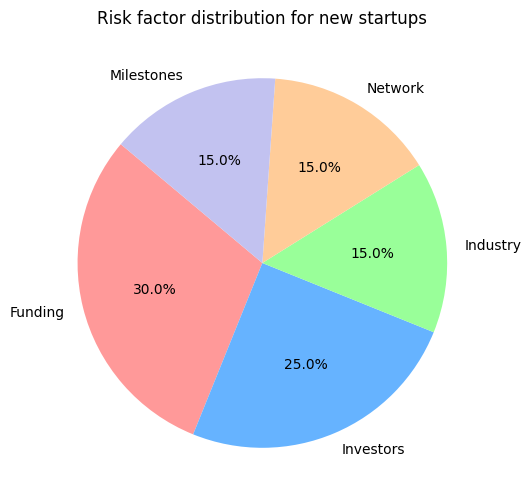

In [ ]:
import matplotlib.pyplot as plt

labels = ["Funding", "Investors", "Industry", "Network", "Milestones"]
sizes = [30, 25, 15, 15, 15]  # adjust based on importance
colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99","#c2c2f0"]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Risk factor distribution for new startups")
plt.show()


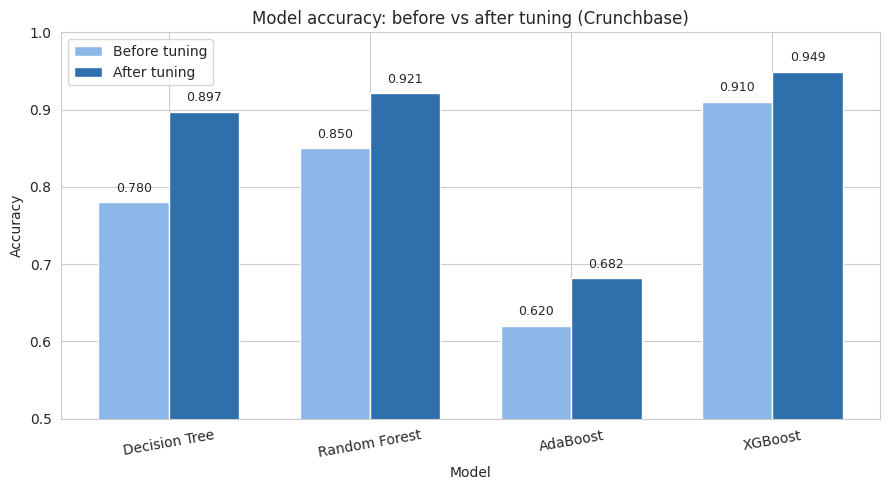

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Models and accuracies
models = ["Decision Tree", "Random Forest", "AdaBoost", "XGBoost"]
acc_before = [0.78, 0.85, 0.62, 0.91]   # baseline values
acc_after  = [0.8968, 0.9212, 0.6818, 0.9492]  # tuned values

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,5))
sns.set_style("whitegrid")

bars1 = plt.bar(x - width/2, acc_before, width, label="Before tuning", color="#8bb8e8")
bars2 = plt.bar(x + width/2, acc_after,  width, label="After tuning",  color="#2f6fab")

plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Model accuracy: before vs after tuning (Crunchbase)")
plt.xticks(x, models, rotation=10)
plt.ylim(0.5, 1.0)
plt.legend()

# Add values on top of bars
for b in bars1+bars2:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f"{b.get_height():.3f}",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/finale.csv')  # ya finale.xlsx


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col].astype(str))

X = pd.get_dummies(X, drop_first=True)


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive'))


['Colab Notebooks', '772ad912-3817-4aad-a2c6-e52943f5f450.jpeg', 'Untitled document (27).gdoc', 'Untitled document (26).gdoc', 'Untitled document (25).gdoc', 'Exp 4 MPL.gdoc', 'Untitled document (24).gdoc', 'WhatsApp Image 2025-04-20 at 8.50.57 PM.jpeg', 'prodigy-payment.jpeg', 'Screenshot 2025-04-29 210115.png', 'Untitled document (23).gdoc', 'Screenshot 2025-05-14 193306.png', 'Untitled document (22).gdoc', 'Untitled document (21).gdoc', 'Untitled document (20).gdoc', 'Untitled document (19).gdoc', 'Untitled document (18).gdoc', 'AIDS MODULE 4.gdoc', 'AIDS MODULE 6_pc.gdoc', 'MODULE 2.gdoc', 'MODULE 5.gdoc', 'MODULE 3.gdoc', 'MODULE 1.gdoc', 'EHF MODULE 5.gdoc', 'EHF MODULE 1.gdoc', 'ehf MODULE 2.gdoc', 'EHF MODULE 3.gdoc', 'EHF MODULE 6.gdoc', 'EHF MODULE 4.gdoc', 'Untitled document (17).gdoc', 'PALAK CHANCHLANI Resume .gdoc', 'Untitled document (16).gdoc', 'Palak resume-final.gdoc', 'Palak Chanchlani - Complete Project Interview Notes.gdoc', 'Perfect Palak 💯.gdoc', 'Untitled docume

In [ ]:
# Assuming df is your cleaned DataFrame
df.to_csv("/content/crunchbase_cleaned.csv", index=False)
print("Saved cleaned dataset as crunchbase_cleaned.csv")


Saved cleaned dataset as crunchbase_cleaned.csv


In [ ]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("/content/crunchbase_cleaned.csv")

# 1. Shape check
print("Shape:", df.shape)

# 2. Missing values check
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# 3. Data types check
print("Data types:")
print(df.dtypes)

# 4. Target column unique values
print("Target column distribution:")
print(df['status'].value_counts())


Shape: (196498, 26)
Missing values per column:
object_id              195260
funded_object_id_y     192077
funded_object_id       191703
acquiring_object_id    191651
acquired_object_id     187105
parent_id              184749
funded_object_id_x     178647
raised_amount_usd      164795
country_code           108563
founded_at             105317
dtype: int64
Data types:
id                              object
category_code                   object
status                          object
founded_at                      object
logo_width                       int64
logo_height                      int64
country_code                    object
investment_rounds                int64
invested_companies               int64
funding_rounds                   int64
funding_total_usd              float64
milestones                       int64
relationships                    int64
object_id                       object
raised_amount_usd              float64
acquiring_object_id             object
num_

In [ ]:
df = pd.read_csv("/content/crunchbase_cleaned.csv")
print(df.shape)
print(df.isnull().sum().sum())


(196498, 26)
1773233


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/finale.csv")


In [ ]:
drop_cols = ['object_id','funded_object_id_y','funded_object_id','acquiring_object_id',
             'acquired_object_id','parent_id','funded_object_id_x']
df = df.drop(columns=drop_cols)

num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna("NA")

df['status'] = df['status'].map({'operating':1,'acquired':1,'ipo':1,'closed':0})

from sklearn.preprocessing import LabelEncoder
for col in cat_cols.drop('status'):
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [ ]:
df.to_csv("/content/crunchbase_cleaned.csv", index=False)


In [ ]:
df = pd.read_csv("/content/crunchbase_cleaned.csv")
print(df.shape)
print(df.isnull().sum().sum())


(196498, 19)
0


In [ ]:
from imblearn.over_sampling import SMOTE

# Assume X_train, y_train already defined from train/test split
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", X_res.shape, y_res.shape)


After SMOTE: (586784, 17) (586784,)


In [ ]:
smote_df = pd.DataFrame(X_res, columns=X_train.columns)
smote_df['status'] = y_res

smote_df.to_csv("/content/smote_dataset.csv", index=False)

import os
size_bytes = os.path.getsize("/content/smote_dataset.csv")
size_mb = size_bytes / (1024*1024)
print(f"SMOTE dataset file size: {size_mb:.2f} MB")


SMOTE dataset file size: 60.86 MB


Startup Success vs Failure:
status
1    193914
0      2584
Name: count, dtype: int64


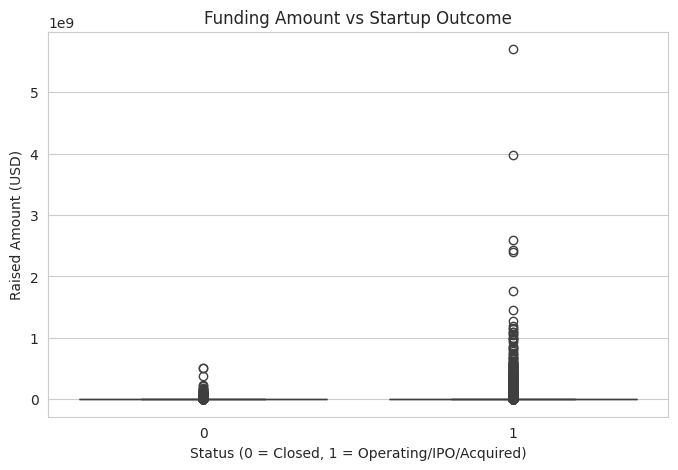

Top 10 Categories by Success Rate:
category_code
30    1.000000
19    1.000000
14    1.000000
28    1.000000
0     0.998773
9     0.996552
18    0.996047
16    0.995286
40    0.993852
6     0.993805
Name: status, dtype: float64
High-risk startups flagged: 9124
Minimum funding required for 70% success rate: $0


In [ ]:
# Business Insights from Crunchbase Cleaned Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("/content/crunchbase_cleaned.csv")

# 1. Status Distribution
status_counts = df['status'].value_counts()
print("Startup Success vs Failure:")
print(status_counts)

# 2. Funding vs Success
plt.figure(figsize=(8,5))
sns.boxplot(x='status', y='raised_amount_usd', data=df)
plt.title("Funding Amount vs Startup Outcome")
plt.xlabel("Status (0 = Closed, 1 = Operating/IPO/Acquired)")
plt.ylabel("Raised Amount (USD)")
plt.show()

# 3. Top Categories by Success Rate
if 'category_code' in df.columns:
    success_rate = df.groupby('category_code')['status'].mean().sort_values(ascending=False).head(10)
    print("Top 10 Categories by Success Rate:")
    print(success_rate)

# 4. Risk Flag: Low funding + high competition
df['risk_flag'] = ((df['raised_amount_usd'] < df['raised_amount_usd'].median()) &
                   (df['relationships'] > df['relationships'].median())).astype(int)
print("High-risk startups flagged:", df['risk_flag'].sum())

# 5. Strategic Insight: Funding threshold for 70% success
thresholds = df.groupby('raised_amount_usd')['status'].mean()
success_threshold = thresholds[thresholds >= 0.7].index.min()
print(f"Minimum funding required for 70% success rate: ${success_threshold:,.0f}")


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rand_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring="accuracy", n_jobs=-1, random_state=42
)

rand_search.fit(X_train, y_train)

print("Best params:", rand_search.best_params_)
print("Best CV accuracy:", rand_search.best_score_)
best_model = rand_search.best_estimator_
print("Test accuracy:", accuracy_score(y_test, best_model.predict(X_test)))


Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Best CV accuracy: 0.9868255322113201
Test accuracy: 0.9868193384223919


In [ ]:
import pickle

# Suppose best_model is your trained RandomForest/XGBoost model
with open("crunchbase_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Later load karne ke liye:
with open("crunchbase_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Test
print("Loaded model accuracy:", loaded_model.score(X_test, y_test))


Loaded model accuracy: 0.9868193384223919
